In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision

    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys 
    !{sys.executable} -m pip install ncut-pytorch[vision]
    !{sys.executable} -m pip install matplotlib ipympl widgetsnbextension

In [3]:
import torch
from ncut_pytorch.predictor import NcutDinoPredictorSR, NcutDinoPredictor, NcutDinov3Predictor
from PIL import Image
import numpy as np

In [4]:
is_cuda = torch.cuda.is_available()
input_size = (2048, 2048)
if is_cuda:
    predictor = NcutDinov3Predictor(input_size=input_size, batch_size=1)
    predictor = predictor.to('cuda')
else:
    predictor = NcutDinov3Predictor(input_size=input_size, batch_size=1)
    predictor = predictor.to('cpu')

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main


In [5]:
default_images = ['./images/view_0.jpg', './images/view_1.jpg', './images/view_2.jpg',
                  './images/view_3.jpg', './images/view_ego.jpg', './images/image2.jpg']

images = [Image.open(image_path) for image_path in default_images]
predictor.set_images(images)

In [6]:
%matplotlib widget

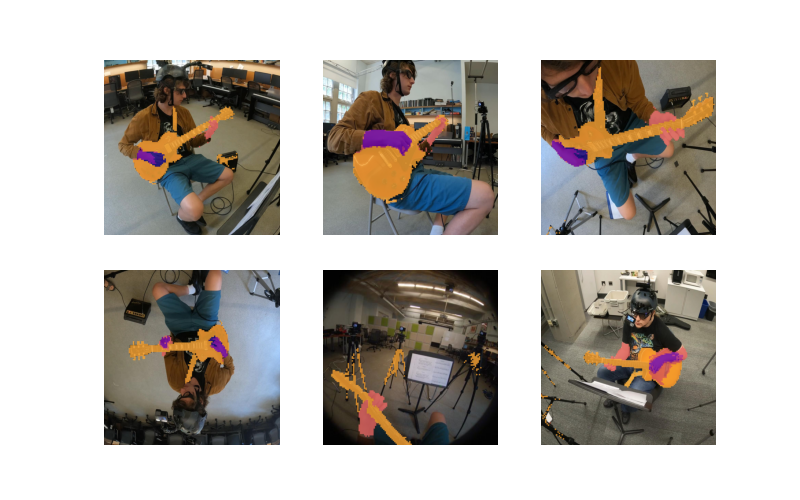

In [7]:
masks = predictor.preview([300, 579], 0)

import matplotlib.pyplot as plt

def blend_mask(img, mask, alpha=0.8):
    mask = mask.resize((img.width, img.height), resample=Image.Resampling.NEAREST)
    img = np.array(img).astype(np.float32)
    mask = np.array(mask).astype(np.float32)
    blend = img * (1 - alpha) + mask * alpha
    h, w = blend.shape[:2]
    blend = blend.reshape(h*w, 3)
    mask = mask.reshape(h*w, 3)
    img = img.reshape(h*w, 3)
    blend[mask[:, 0] == 255] = img[mask[:, 0] == 255]
    blend = blend.reshape(h, w, 3)
    blend = blend.astype(np.uint8)
    return Image.fromarray(blend)

def plot_masks(images, masks, fig, axes):
    color_values = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
    color_values = plt.get_cmap('plasma_r')(color_values)
    color_values = (color_values * 255).astype(np.uint8)

    for idx, (ax, img) in enumerate(zip(axes, images)):
        ax.clear()
        mask = np.ones((*masks[0][0].shape, 3)) * 255
        mask = mask.astype(np.uint8)
        for i in range(len(color_values)):
            mask[masks[i][idx]] = color_values[i][:3]
        mask_img = Image.fromarray(mask)
        ax.imshow(blend_mask(img, mask_img, alpha=0.8))
        ax.set_axis_off()
    fig.canvas.draw_idle()

fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.flatten()
plot_masks(images, masks, fig, axes)

def on_click(event):
    if event.inaxes is None or event.xdata is None or event.ydata is None:
        return
    for idx, ax in enumerate(axes):
        if ax == event.inaxes:
            x, y = event.xdata, event.ydata
            # Recompute masks for all images, using the hovered coordinates and image index
            masks_new = predictor.preview([x, y], idx)
            plot_masks(images, masks_new, fig, axes)
            break

cid = fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()